# Проект: Принятие решений в бизнесе

Цель проекта: приоритизировать гипотезы и проанализировать результаты A/B-теста для увеличения выручки.  

Задачи:  
1. провести приоритезацию гипотез по фреймворкам ICE и RICE;  
2. проанализировать A/B-тест и построить графики изменений между группами; 
2. определить границу для аномальных пользователей; 
3. посчитать статистическую значимость различий в среднем количестве заказов и среднем чеке между группами;
4. принять решение об остановке или продолжении теста.

## Описание данных

Файл /datasets/hypothesis.csv. 
- Hypothesis — краткое описание гипотезы;
- Reach — охват пользователей по 10-балльной шкале;
- Impact — влияние на пользователей по 10-балльной шкале;
- Confidence — уверенность в гипотезе по 10-балльной шкале;
- Efforts — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы.

Файл /datasets/orders.csv.
- transactionId — идентификатор заказа;
- visitorId — идентификатор пользователя, совершившего заказ;
- date — дата, когда был совершён заказ;
- revenue — выручка заказа;
- group — группа A/B-теста, в которую попал заказ.

Файл /datasets/visitors.csv. 
- date — дата;
- group — группа A/B-теста;
- visitors — количество пользователей в указанную дату в указанной группе A/B-теста

## Загрузка данных

In [1]:
#загружаем нужные библиотеки
import pandas as pd
from datetime import datetime, timedelta 
import matplotlib.pyplot as plt 
import scipy.stats as stats
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#загружаем данные
try:
    hypothesis, orders, visitors = (
        pd.read_csv('/datasets/hypothesis.csv'),
        pd.read_csv('/datasets/orders.csv'),
        pd.read_csv('/datasets/visitors.csv')
    )


except:
    hypothesis, orders, visitors = (
        pd.read_csv('hypothesis.csv'),
        pd.read_csv('orders.csv'),
        pd.read_csv('visitors.csv')
    )

In [3]:
hypothesis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 492.0+ bytes


In [4]:
# снимаем ограничение на ширину столбцов
pd.set_option('display.max_colwidth', None)

# смотрим, какие есть гипотезы
hypothesis

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


In [5]:
# смотрим на таблицу заказов
orders.info()
print(orders)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB
      transactionId   visitorId        date  revenue group
0        3667963787  3312258926  2019-08-15     1650     B
1        2804400009  3642806036  2019-08-15      730     B
2        2961555356  4069496402  2019-08-15      400     A
3        3797467345  1196621759  2019-08-15     9759     B
4        2282983706  2322279887  2019-08-15     2308     B
...             ...         ...         ...      ...   ...
1192     2662137336  3733762160  2019-08-14     6490     B
1193     2203539145   370388673  2019-08-14     3190     A
1194     18

In [6]:
# ищем пропуски
display(orders.isna().sum())

#ищем дубликаты 
display(orders.duplicated().sum())

# пропусков и дубликатов нет

transactionId    0
visitorId        0
date             0
revenue          0
group            0
dtype: int64

0

In [7]:
# смотрим на таблицу пользователей 
visitors.info()
print(visitors)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB
          date group  visitors
0   2019-08-01     A       719
1   2019-08-02     A       619
2   2019-08-03     A       507
3   2019-08-04     A       717
4   2019-08-05     A       756
..         ...   ...       ...
57  2019-08-27     B       720
58  2019-08-28     B       654
59  2019-08-29     B       531
60  2019-08-30     B       490
61  2019-08-31     B       718

[62 rows x 3 columns]


In [8]:
# ищем пропуски
display(visitors.isna().sum())

#ищем дубликаты 
display(orders.duplicated().sum())

# пропусков и дубликатов нет

date        0
group       0
visitors    0
dtype: int64

0

## Предобработка данных

In [9]:
# приводим названия столбцов к нижнему регистру
hypothesis.columns = hypothesis.columns.str.lower()
hypothesis

,hypothesis,reach,impact,confidence,efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


In [10]:
# приводим колонки с датой к формату datetime
visitors['date'] = pd.to_datetime(visitors['date'])
orders['date'] = pd.to_datetime(orders['date'])

In [11]:
# сколько групп в АВ-тесте
orders['group'].unique()

array(['B', 'A'], dtype=object)

В тесте две группы.

In [12]:
# дата начала теста
orders['date'].min()

Timestamp('2019-08-01 00:00:00')

In [13]:
# дата окончания теста
orders['date'].max()

Timestamp('2019-08-31 00:00:00')

Начало теста: 1 августа 2019, конец: 31 августа 2019.

In [14]:
# количество пользователей в группах
group_user_count = orders.groupby(['group']).agg({'visitorId':'nunique'}).reset_index()
group_user_count

,group,visitorId
0,A,503
1,B,586


В группе А - 503 пользователя, в группе В - 586.

In [15]:
# сколько пользователей попали в обе группы
orders.groupby('visitorId').agg({'group' : 'nunique'}).query('group>1').count()

group    58
dtype: int64

In [16]:
print('Процент двойников от всех пользователей в группе А:', round(58/(503)*100))
print('Процент двойников от всех пользователей в группе B:', round(58/(586)*100))

Процент двойников от всех пользователей в группе А: 12
Процент двойников от всех пользователей в группе B: 10


Есть 58 пользователей, попавших в обе группы. Так как они составляют 12% от общего количества пользователей в группе А и 10% в группе В, удалить мы их не можем.

In [17]:
# динамика посетителей по дням по группам
visitorsADaily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']

visitorsBDaily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']

daily_visitors=visitorsADaily.merge(visitorsBDaily, left_on='date', right_on='date', how='left')
daily_visitors['difference']=daily_visitors['visitorsPerDateB']-daily_visitors['visitorsPerDateA'] # разница в количестве посетителей
daily_visitors

,date,visitorsPerDateA,visitorsPerDateB,difference
0,2019-08-01,719,713,-6
1,2019-08-02,619,581,-38
2,2019-08-03,507,509,2
3,2019-08-04,717,770,53
4,2019-08-05,756,707,-49
5,2019-08-06,667,655,-12
6,2019-08-07,644,709,65
7,2019-08-08,610,654,44
8,2019-08-09,617,610,-7
9,2019-08-10,406,369,-37


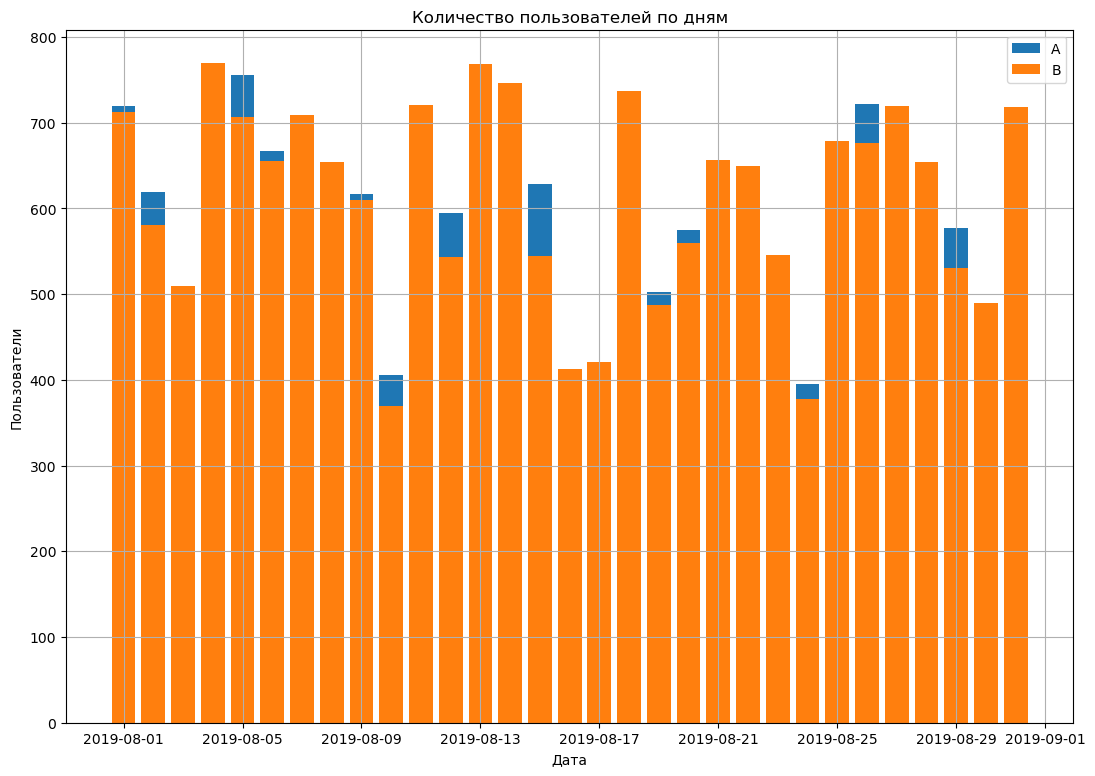

In [18]:
# визуализируем
plt.rcParams['figure.figsize'] = [13, 9]; #корректируем размер графика

# посетители группы А
plt.bar(daily_visitors['date'], daily_visitors['visitorsPerDateA'], label='A')
# посетители группы В
plt.bar(daily_visitors['date'], daily_visitors['visitorsPerDateB'], label='B')

plt.legend()

plt.grid (True)
plt.title('Количество пользователей по дням')
plt.xlabel('Дата')
plt.ylabel('Пользователи');

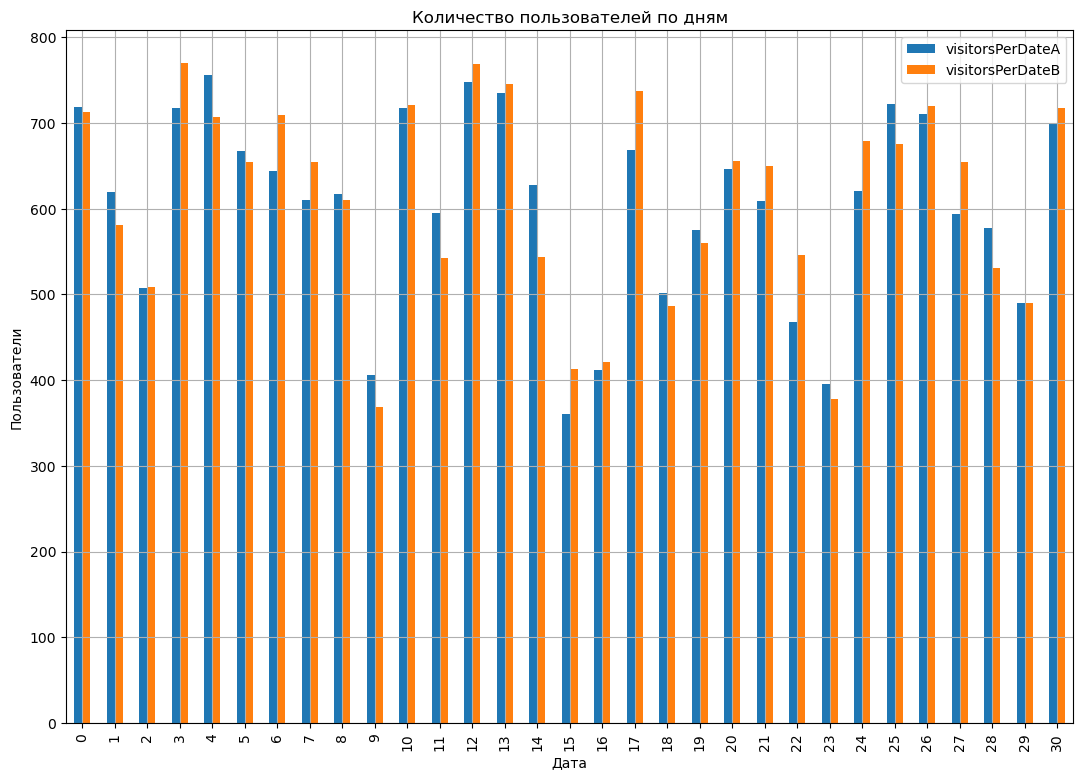

In [19]:
# сравнение side by side
plt.rcParams['figure.figsize'] = [13, 9]; #корректируем размер графика
daily_visitors[['visitorsPerDateA', 'visitorsPerDateB']].plot(kind='bar', stacked=False)
plt.legend()
plt.grid (True)
plt.title('Количество пользователей по дням')
plt.xlabel('Дата')
plt.ylabel('Пользователи');

На этих двух графиках мы видим, в какие дни было больше посетителей в той или иной группе. Всего в день было приблизительно от 350 до 750 посетителей. Чаще всего посетителей в группе В было больше, но были дни, когда лидировала группа А (например, 15 августа в группе А было на 84 посетителей больше, чем в В). 

<div class="alert alert-success">
<h2> Комментарий ревьюера 😊<a class="tocSkip"> </h2>
  
Замечательная работа)

## Часть 1. Приоритизация гипотез

Применяем фреймворк ICE для приоритизации гипотез и сортируем их по убыванию приоритета.

In [20]:
hypothesis['ICE']= (hypothesis['impact'] * hypothesis['confidence']) / hypothesis['efforts']
hypothesis['ICE']= round(hypothesis['ICE'], 2)
display(hypothesis[['hypothesis', 'ICE']].sort_values(by='ICE', ascending=False))

,hypothesis,ICE
8,"Запустить акцию, дающую скидку на товар в день рождения",16.20
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.33
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.20
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.00
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.00
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.00
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.33
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.12
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.00


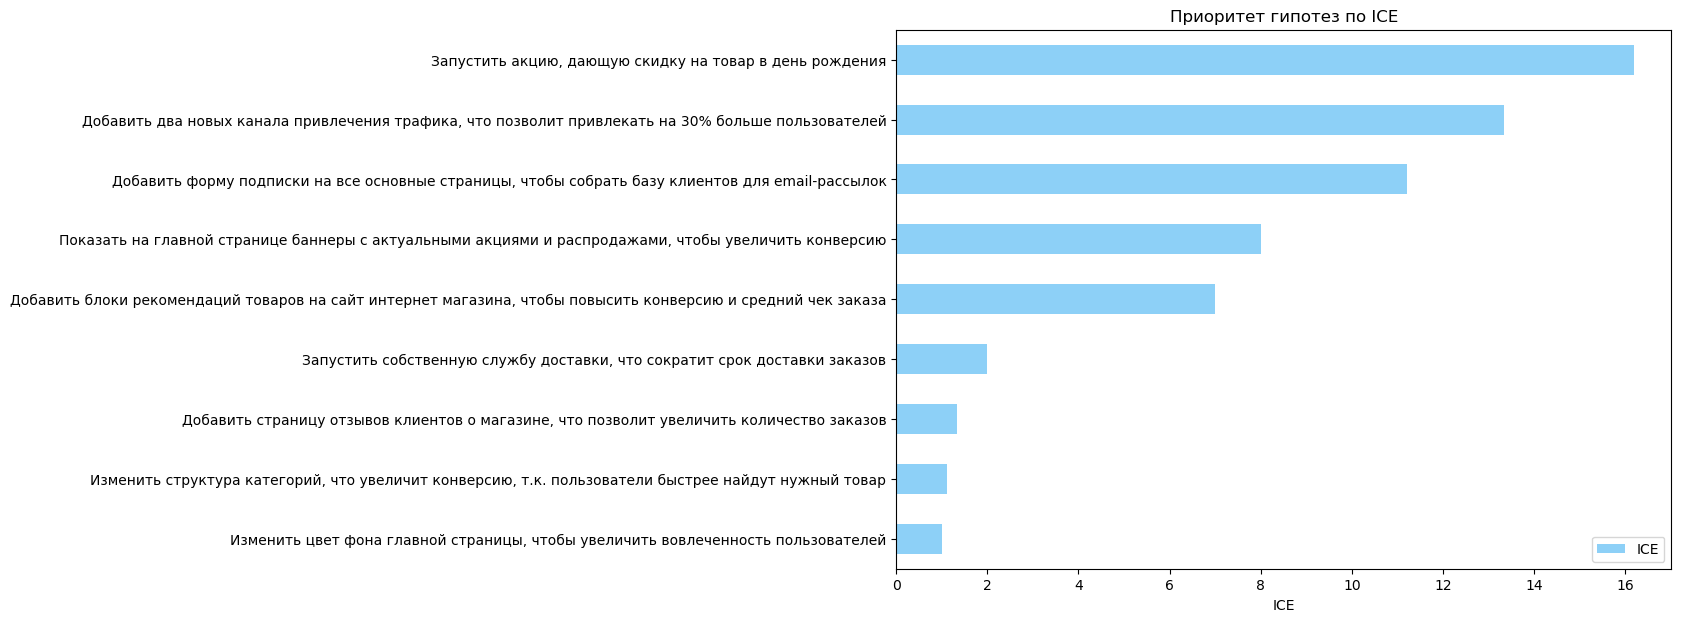

In [21]:
#визуализируем приоритезацию гипотез по ICE
hypothesis[['hypothesis', 'ICE']].set_index('hypothesis').sort_values(by='ICE', ascending=True).plot(kind='barh', color ='#8dd0f7', figsize=(10,7))
plt.title('Приоритет гипотез по ICE')
plt.xlabel('ICE') 
plt.ylabel('');

Наиболее перспективные гипотезы по ICE - 8 (скидка на товар в день рождения), 0 (добавить 2 канала привлечения трафика), 7 (добавить форму подписки).

Применяем фреймворк RICE для приоритизации гипотез и сортируем их по убыванию приоритета.

In [22]:
hypothesis['RICE']= (hypothesis['reach'] * hypothesis['impact'] * hypothesis['confidence']) / hypothesis['efforts']
hypothesis['RICE']= round(hypothesis['RICE'], 2)
display(hypothesis[['hypothesis', 'RICE']].sort_values(by='RICE', ascending=False))

,hypothesis,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3.0


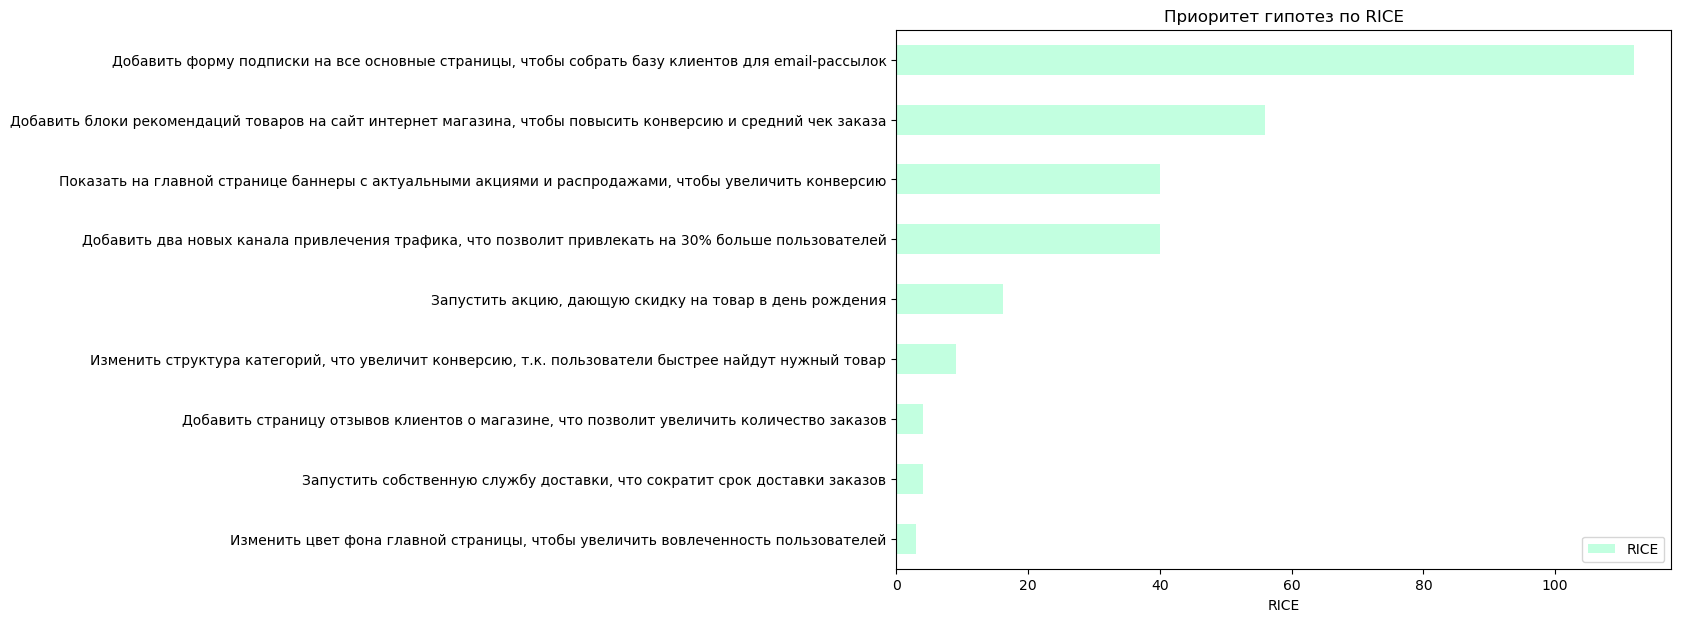

In [23]:
#визуализируем приоритезацию гипотез по RICE
hypothesis[['hypothesis', 'RICE']].set_index('hypothesis').sort_values(by='RICE', ascending=True).plot(kind='barh', color ='#c2ffe0', figsize=(10,7))
plt.title('Приоритет гипотез по RICE')
plt.xlabel('RICE') 
plt.ylabel('');

Теперь самые перспективные гипотезы - это 7, 2 (добавить блоки рекомендаций), третье место делят гипотезы 6(показ баннеров с акциями) и 0. Приоритет гипотез изменился из-за добавления параметра reach, который показывает, сколько пользователей будет затронуто. Гипотеза 7 обладает самым высоким параметром reach, также высокий этот параметр у гипотезы 2. У гипотезы 0 низкий параметр reach, зато очень высокий impact, поэтому он также вошел в топ-3. У гипотезы 6 низкий impact и средний reach, но высокий confidence.

## Часть 2. Анализ A/B-теста

### 1. График кумулятивной выручки по группам

In [24]:
# создаем массив уникальных пар значений дат и групп теста
datesGroups = orders[['date','group']].drop_duplicates()

# получаем агрегированные кумулятивные по дням данные о заказах 
ordersAggregated = datesGroups.apply(lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])]\
.agg({'date' : 'max', 'group' : 'max', 'transactionId' : 'nunique', 'visitorId' : 'nunique', 'revenue' : 'sum'}), axis=1).sort_values(by=['date','group'])

# получаем агрегированные кумулятивные по дням данные о посетителях интернет-магазина 
visitorsAggregated = datesGroups.apply(lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group'])].agg({'date' : 'max', 'group' : 'max', 'visitors' : 'sum'}), axis=1).sort_values(by=['date','group'])

# объединяем кумулятивные данные в одной таблице и присваиваем ее столбцам понятные названия
cumulativeData = ordersAggregated.merge(visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group'])
cumulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

print(cumulativeData.head(5))

        date group  orders  buyers  revenue  visitors
0 2019-08-01     A      24      20   148579       719
1 2019-08-01     B      21      20   101217       713
2 2019-08-02     A      44      38   242401      1338
3 2019-08-02     B      45      43   266748      1294
4 2019-08-03     A      68      62   354874      1845


In [25]:
# смотрим, совпадают ли даты начала и окончания теста в новом датафрейме с исзодными данными
print(cumulativeData['date'].min())
print(cumulativeData['date'].max())

2019-08-01 00:00:00
2019-08-31 00:00:00


Даты совпадают, все в порядке.

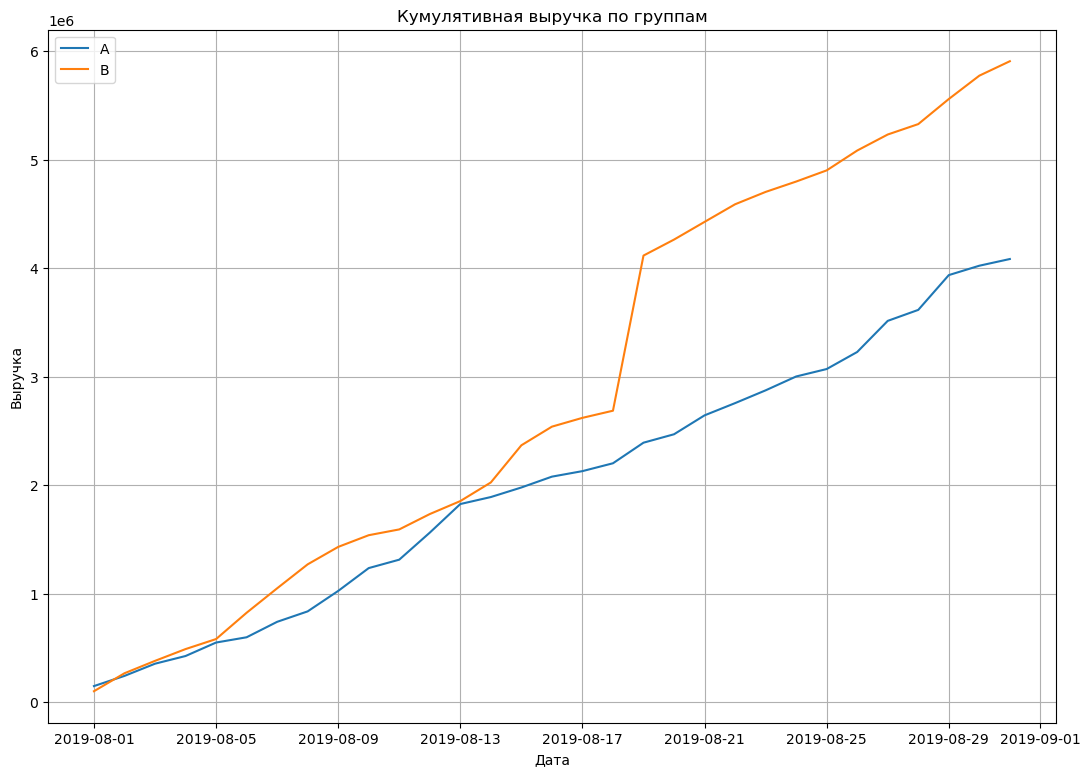

In [26]:
# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А
cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]

# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе B
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]

plt.rcParams['figure.figsize'] = [13, 9]; #корректируем размер графика

# Строим график выручки группы А
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A')

# Строим график выручки группы B
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B')

plt.title('Кумулятивная выручка по группам')
plt.legend()
plt.grid (True)
plt.xlabel('Дата')
plt.ylabel('Выручка');

Выручка растет в течение всего теста, но в группе B наблюдается резкий скачок между 17 и 21 августа: либо увеличилось число заказов, либо они были дорогостоящими.

### 2. График кумулятивного среднего чека по группам

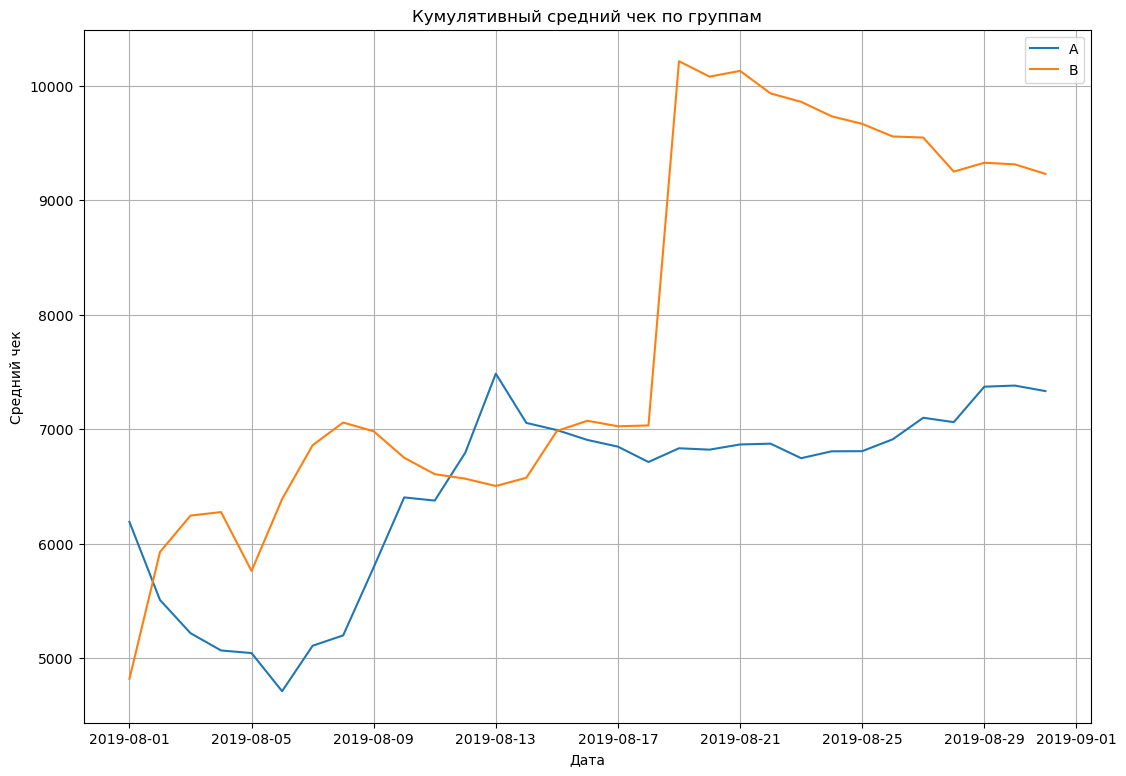

In [27]:
plt.rcParams['figure.figsize'] = [13, 9]; #корректируем размер графика
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='B')
plt.title('Кумулятивный средний чек по группам')
plt.legend()
plt.grid (True)
plt.xlabel('Дата')
plt.ylabel('Средний чек');

Средний чек не стал равномерным к концу теста: мы наблюдаем тот же скачок - видимо, заказы были аномально дорогими.

### 3. График относительного изменения кумулятивного среднего чека группы B к группе A

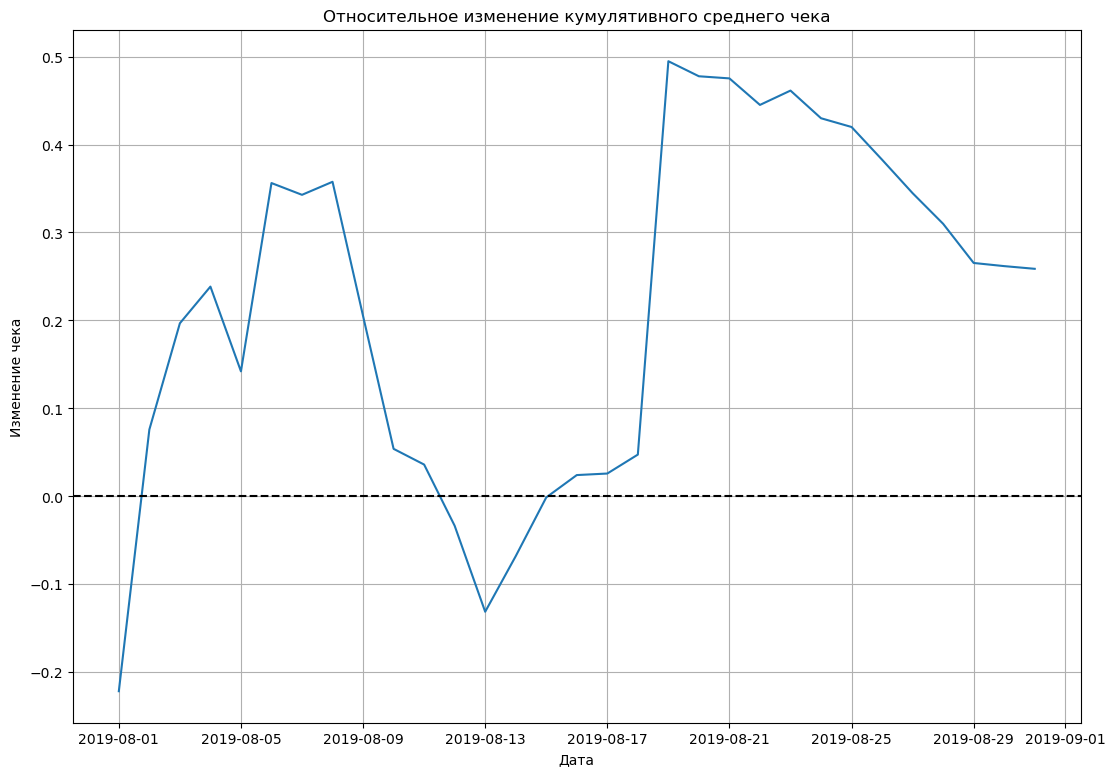

In [28]:
# собираем данные в одном датафрейме
mergedCumulativeRevenue = cumulativeRevenueA.merge(cumulativeRevenueB, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

# cтроим отношение средних чеков

plt.rcParams['figure.figsize'] = [13, 9]; #корректируем размер графика
plt.plot(mergedCumulativeRevenue['date'], (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])/(mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1)

# добавляем ось X
plt.axhline(y=0, color='black', linestyle='--')
plt.grid (True)
plt.title('Относительное изменение кумулятивного среднего чека')
plt.xlabel('Дата')
plt.ylabel('Изменение чека');

График скачет - видимо, есть выбросы, которые мы найдем далее.

### 4. График кумулятивного среднего количества заказов на посетителя по группам

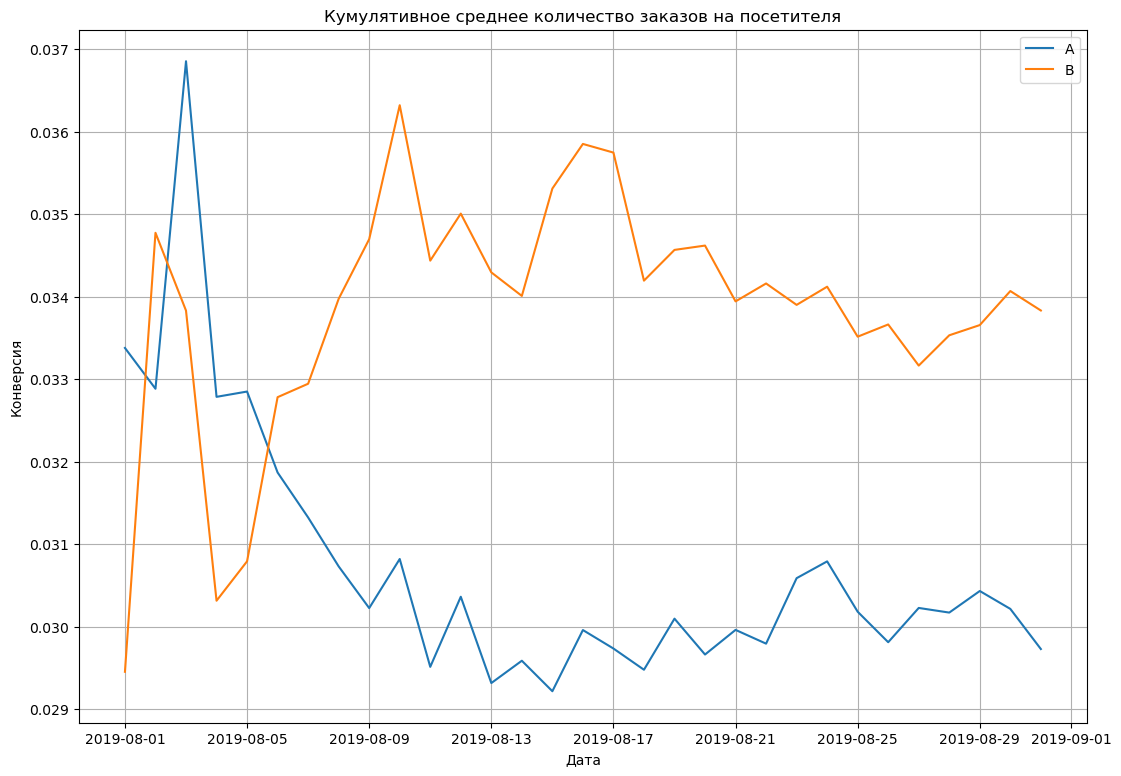

In [29]:
# считаем кумулятивную конверсию
cumulativeData['conversion'] = cumulativeData['orders']/cumulativeData['visitors']

# отделяем данные по группе A
cumulativeDataA = cumulativeData[cumulativeData['group']=='A']

# отделяем данные по группе B
cumulativeDataB = cumulativeData[cumulativeData['group']=='B']

# строим графики
plt.rcParams['figure.figsize'] = [13, 9]; #корректируем размер графика
plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='B')
plt.legend()

plt.grid (True)
plt.title('Кумулятивное среднее количество заказов на посетителя')
plt.xlabel('Дата')
plt.ylabel('Конверсия');

В начале конверсия сильно скачет, но со временем выравнивается. При этом конверсия в группе А изначально была больше, но затем упала, а конверсия в группе В, наоборот, выросла и держится стабильно выше.

### 5. График относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A

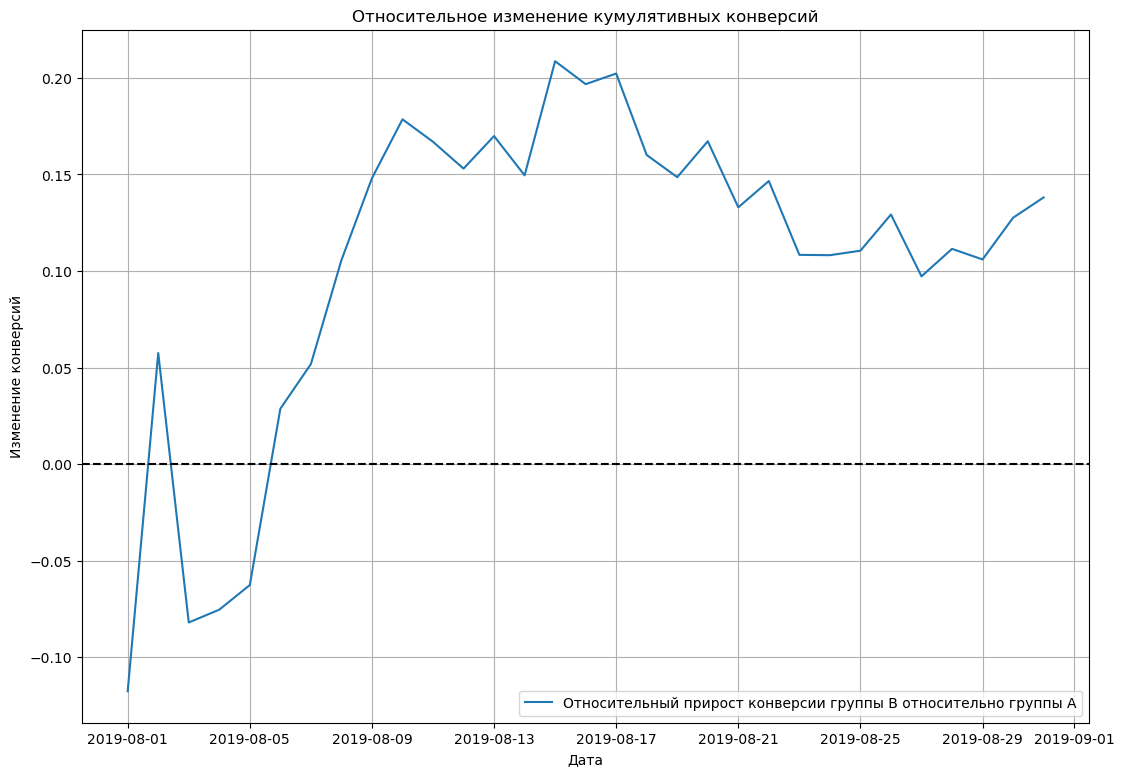

In [30]:
mergedCumulativeConversions = cumulativeDataA[['date','conversion']].merge(cumulativeDataB[['date','conversion']], left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

plt.rcParams['figure.figsize'] = [13, 9]; #корректируем размер графика
plt.plot(mergedCumulativeConversions['date'], mergedCumulativeConversions['conversionB']/mergedCumulativeConversions['conversionA']-1, label="Относительный прирост конверсии группы B относительно группы A")
plt.legend()

plt.axhline(y=0, color='black', linestyle='--')

plt.grid (True)
plt.title('Относительное изменение кумулятивных конверсий')
plt.xlabel('Дата')
plt.ylabel('Изменение конверсий');

В начале конверсия была больше у группы А, но позже в группе В конверсия стала выше (минимум на 10%) и держалась на таком уровне до конца теста.

### 6. Точечный график количества заказов по пользователям

In [31]:
# сколько в среднем заказов приходится на пользователя 
ordersByUsers = (
    orders.groupby('visitorId', as_index=False)
    .agg({'transactionId': 'nunique'})
)

ordersByUsers.columns = ['userId', 'orders']

print(ordersByUsers.sort_values(by='orders', ascending=False).head(10)) 

          userId  orders
1023  4256040402      11
591   2458001652      11
569   2378935119       9
487   2038680547       8
44     199603092       5
744   3062433592       5
55     237748145       5
917   3803269165       5
299   1230306981       5
897   3717692402       5


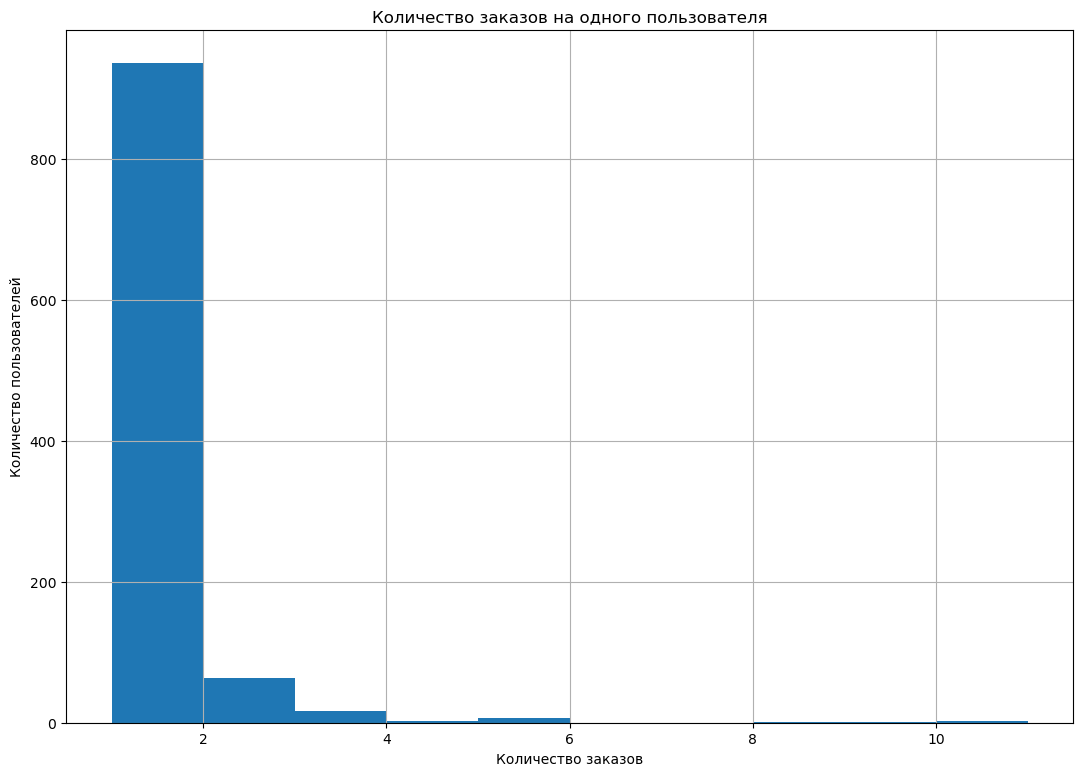

In [32]:
# распределение количества заказов на одного пользователя
plt.rcParams['figure.figsize'] = [13, 9]; #корректируем размер графика
plt.hist(ordersByUsers['orders'])
plt.grid (True)
plt.title('Количество заказов на одного пользователя')
plt.xlabel('Количество заказов')
plt.ylabel('Количество пользователей');

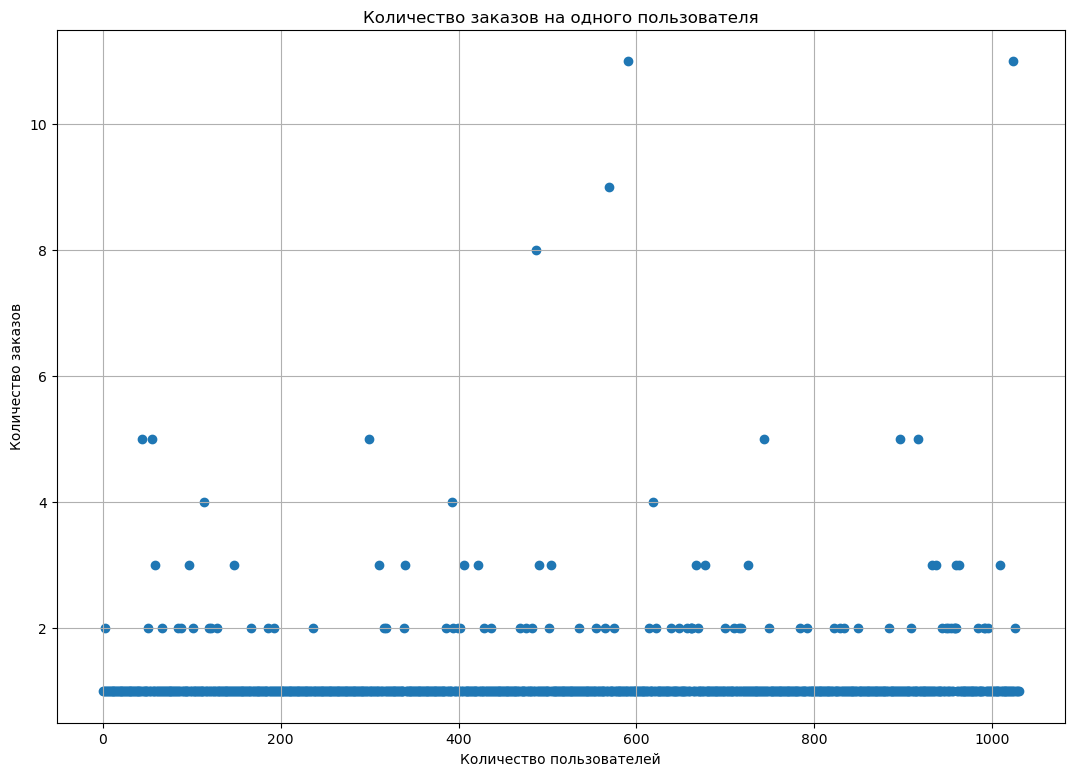

In [33]:
# точечный график количества заказов на одного пользователя
x_values = pd.Series(range(0,len(ordersByUsers)))
plt.rcParams['figure.figsize'] = [13, 9]; #корректируем размер графика
plt.scatter(x_values, ordersByUsers['orders'])
plt.grid (True)
plt.title('Количество заказов на одного пользователя')
plt.xlabel('Количество пользователей')
plt.ylabel('Количество заказов');

Большинство пользователей сделали один заказ. Есть значительная доля тех, кто сделали 2-3 заказа. Отдельные пользователи совершили 8-11 заказов, их можно считать аномалиями, точную границу мы опеределим в следующем этапе. Интересно, что по графику мы не видим пользователей  с 6-7 и 10 заказами.

In [34]:
ordersByUsers['orders'].unique()

array([ 1,  2,  5,  3,  4,  8,  9, 11], dtype=int64)

Действительно, пользователей с таким количеством заказов нет. Скорее всего, покупатели совершают 1-2 заказа, а все остальные попадут в аномалии.

### 7. 95-й и 99-й перцентили количества заказов на пользователя. Граница для определения аномальных пользователей

In [35]:
np.percentile(ordersByUsers['orders'], [95, 99])

array([2., 4.])

Наши предположения подтвердились - не более 5% пользователей оформили более 2 заказов и только 1% - более 4. Таким образом, верхняя граница составит 2 заказа, а покупатели, совершившие 3 и более заказов, будут отсеяны далее.

### 8. Точечный график стоимостей заказов

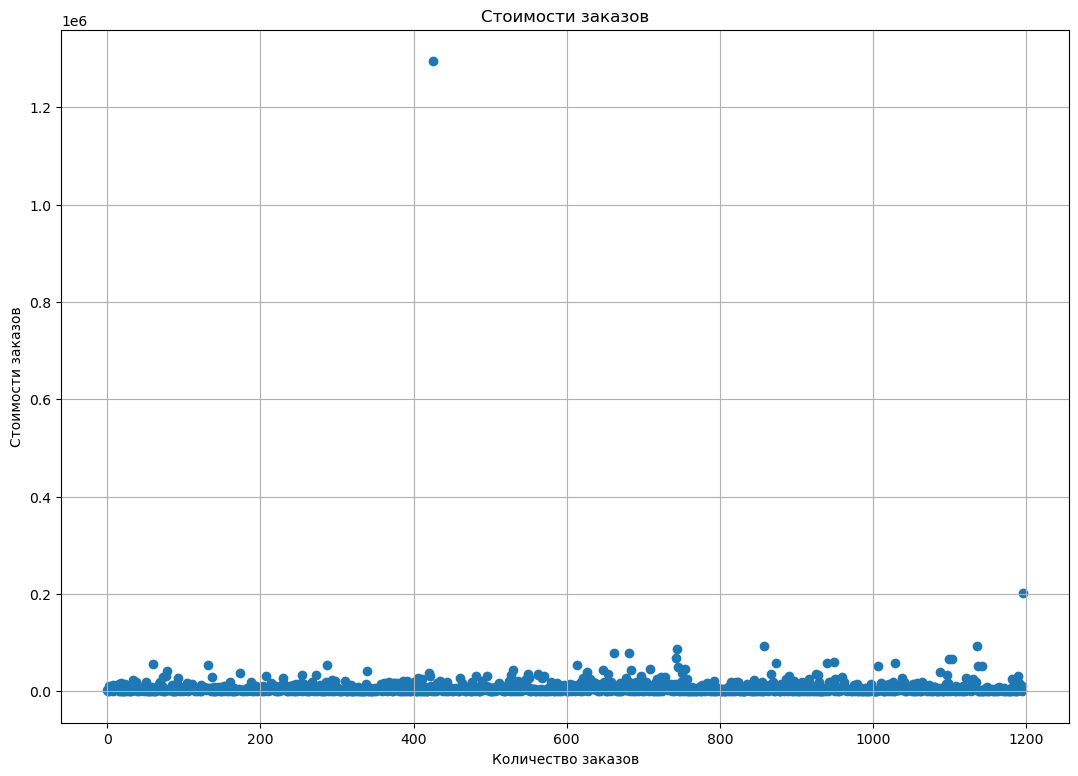

In [36]:
x_values = pd.Series(range(0,len(orders)))
plt.rcParams['figure.figsize'] = [13, 9]; #корректируем размер графика
plt.scatter(x_values, orders['revenue'])
plt.grid (True)
plt.title('Стоимости заказов')
plt.xlabel('Количество заказов')
plt.ylabel('Стоимости заказов');

Большая часть заказов находятся в одном ценовом диапазоне до 200 тыс., но мы также видим очевидный выброс в 1,3 млн., и менее очевидный в 200 тыс., который, тем не менее, тоже выбивается из большинства. Построим еще один график без этих значений.  

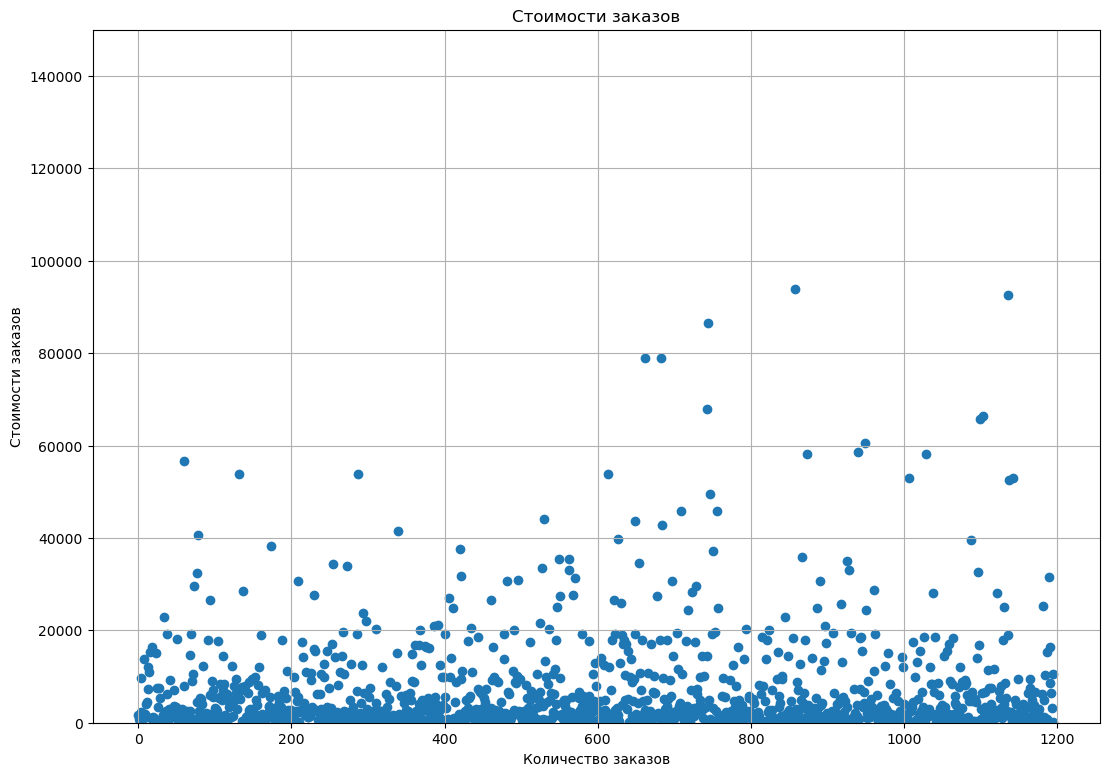

In [37]:
# график без аномалий
x_values = pd.Series(range(0,len(orders)))
plt.rcParams['figure.figsize'] = [13, 9]; #корректируем размер графика
plt.ylim(0, 150000)
plt.scatter(x_values, orders['revenue'])
plt.grid (True)
plt.title('Стоимости заказов')
plt.xlabel('Количество заказов')
plt.ylabel('Стоимости заказов');

Оказывается, стоимость заказов не превышает 100 тыс., а большинство заказов находятся в диапазоне до 20 тыс. Посмотрим на перцентили, чтобы точнее определить это значение и определить границу аномальных заказов.

### 9. 95-й и 99-й перцентили стоимости заказов. Граница для определения аномальных заказов

In [38]:
np.percentile(orders['revenue'], [90, 95, 99])

array([18168. , 28000. , 58233.2])

90% заказов стоят менее 18168. Не более 5% находятся в диапазоне до 28 тыс., не более 1% - до 58 тыс. Учитывая, что большая часть заказов не превышают 20 тыс, опередляем границу аномальных заказов как 95-й перцентиль, то есть 28 тыс.

### 10. Статистическая значимость различий в среднем количестве заказов на посетителя между группами по «сырым» данным

Проанализируем различия между группами по «сырым» данным - без удаления аномалий. Для начала сформулируем гипотезы.  
Нулевая гипотеза:  различий в среднем количестве заказов на посетителя между группами нет.   
Альтернативная гипотеза: различия в среднем количестве заказов на посетителя есть.

In [39]:
# готовим данные: делаем таблицу пользователей по группам

visitorsADaily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']

visitorsACummulative = visitorsADaily.apply(
    lambda x: visitorsADaily[visitorsADaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateA': 'sum'}
    ),
    axis=1,
)
visitorsACummulative.columns = ['date', 'visitorsCummulativeA']

visitorsBDaily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']

visitorsBCummulative = visitorsBDaily.apply(
    lambda x: visitorsBDaily[visitorsBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateB': 'sum'}
    ),
    axis=1,
)
visitorsBCummulative.columns = ['date', 'visitorsCummulativeB']


ordersADaily = (
    orders[orders['group'] == 'A'][['date', 'transactionId', 'visitorId', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transactionId': pd.Series.nunique, 'revenue': 'sum'})
)
ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']

ordersACummulative = ordersADaily.apply(
    lambda x: ordersADaily[ordersADaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateA': 'sum', 'revenuePerDateA': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersACummulative.columns = [
    'date',
    'ordersCummulativeA',
    'revenueCummulativeA',
]

ordersBDaily = (
    orders[orders['group'] == 'B'][['date', 'transactionId', 'visitorId', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transactionId': pd.Series.nunique, 'revenue': 'sum'})
)
ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']

ordersBCummulative = ordersBDaily.apply(
    lambda x: ordersBDaily[ordersBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateB': 'sum', 'revenuePerDateB': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersBCummulative.columns = [
    'date',
    'ordersCummulativeB',
    'revenueCummulativeB',
]

data = (
    ordersADaily.merge(
        ordersBDaily, left_on='date', right_on='date', how='left'
    )
    .merge(ordersACummulative, left_on='date', right_on='date', how='left')
    .merge(ordersBCummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsADaily, left_on='date', right_on='date', how='left')
    .merge(visitorsBDaily, left_on='date', right_on='date', how='left')
    .merge(visitorsACummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsBCummulative, left_on='date', right_on='date', how='left')
)

print(data.head(5))

        date  ordersPerDateA  revenuePerDateA  ordersPerDateB  \
0 2019-08-01              24           148579              21   
1 2019-08-02              20            93822              24   
2 2019-08-03              24           112473              16   
3 2019-08-04              16            70825              17   
4 2019-08-05              25           124218              23   

   revenuePerDateB  ordersCummulativeA  revenueCummulativeA  \
0           101217                  24               148579   
1           165531                  44               242401   
2           114248                  68               354874   
3           108571                  84               425699   
4            92428                 109               549917   

   ordersCummulativeB  revenueCummulativeB  visitorsPerDateA  \
0                  21               101217               719   
1                  45               266748               619   
2                  61               38

Мы получили таблицу со следующими столбцами:  
**date** — дата;  
**ordersPerDateA** — количество заказов в выбранную дату в группе A;  
**revenuePerDateA** — суммарная выручка в выбранную дату в группе A;  
**ordersPerDateB** — количество заказов в выбранную дату в группе B;  
**revenuePerDateB** — суммарная выручка в выбранную дату в группе B;  
**ordersCummulativeA** — суммарное число заказов до выбранной даты включительно в группе A;  
**revenueCummulativeA** — суммарная выручка до выбранной даты включительно в группе A;  
**ordersCummulativeB** — суммарное количество заказов до выбранной даты включительно в группе B;  
**revenueCummulativeB** — суммарная выручка до выбранной даты включительно в группе B;  
**visitorsPerDateA** — количество пользователей в выбранную дату в группе A;  
**visitorsPerDateB** — количество пользователей в выбранную дату в группе B;  
**visitorsCummulativeA** — количество пользователей до выбранной даты включительно в группе A;  
**visitorsCummulativeB** — количество пользователей до выбранной даты включительно в группе B.  

Так как мы анализируем данные с выбросами, распределение не нормально, будем использовать непараметрический тест Уилкоксона-Манна-Уитни. Для этого мы подготовим выборки и объявим переменные sampleA и sampleB, в которых пользователям из разных групп будет соответствовать количество заказов. Тем, кто ничего не заказал, будут соответствовать нули. Зададим уровень статистической значимости 0,05.

In [40]:
# Список с количеством заказов для каждого из пользователей из группы А
ordersByUsersA = (
    orders[orders['group'] == 'A']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByUsersA.columns = ['visitorId', 'orders']

# Список с количеством заказов для каждого из пользователей из группы В
ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByUsersB.columns = ['visitorId', 'orders']

# Выборка с числом заказов определённого пользователя из группы А
sampleA = pd.concat(
    [
        ordersByUsersA['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

# Выборка с числом заказов определённого пользователя из группы В
sampleB = pd.concat(
    [
        ordersByUsersB['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

# уровень статистической значимости
alpha=0.05

# p-value
p_value = stats.mannwhitneyu(sampleA, sampleB)[1]
print('P-value равно:', "{0:.3f}".format(stats.mannwhitneyu(sampleA, sampleB)[1]))

if (p_value < alpha):
        print("Отвергаем нулевую гипотезу")
else:
        print("Не получилось отвергнуть нулевую гипотезу")

# относительный проигрыш группы B
print('Относительный прирост среднего числа заказов группы B к А:', "{0:.3f}".format(sampleB.mean() / sampleA.mean() - 1))


P-value равно: 0.017
Отвергаем нулевую гипотезу
Относительный прирост среднего числа заказов группы B к А: 0.138


По результатам теста p-value меньше уровня статистической значимости, значит, отвергаем нулевую гипотезу. Выходит, что по «сырым» данным между группами есть статистически значимая разница в среднем количестве заказов на посетителя. Конверсия заказов в группе В на 13,8% выше, чем в группе А.

### 11. Статистическая значимость различий в среднем чеке заказа между группами по «сырым» данным

Сформулируем гипотезы.  
Нулевая гипотеза: различий в среднем чеке между группами нет.   
Альтернативная гипотеза: различия в среднем чеке между группами есть.  

In [41]:
# уровень статистической значимости
alpha=0.05

# передадим критерию mannwhitneyu() данные о выручке с заказов
p_value = stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])[1]
print('P-value равно:', '{0:.3f}'.format(stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])[1]))
if (p_value < alpha):
        print("Отвергаем нулевую гипотезу")
else:
        print("Не получилось отвергнуть нулевую гипотезу")
# относительный прирост среднего чека группы B
print('Относительный прирост среднего чека группы B к А:','{0:.3f}'.format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1))

P-value равно: 0.729
Не получилось отвергнуть нулевую гипотезу
Относительный прирост среднего чека группы B к А: 0.259


Нулевую гипотезу отвергнуть не получилось, то есть по «сырым» данным статистически значимых различий в среднем чеке между группами нет, даже несмотря на то, что в группе В средний чек выше на 25,9%. Посмотрим, как изменятся результаты тестов с очищенными данным.

### 12. Статистическая значимость различий в среднем количестве заказов на посетителя между группами по «очищенным» данным

Создадим переменную с аномальными пользователями: usersWithManyOrders для тех, кто совершил более 2 заказов и usersWithExpensiveOrders для тех, кто совершил заказы стоимостью более 28000. Гипотезы остаются такими же:   
Нулевая гипотеза:  различий в среднем количестве заказов нет.   
Альтернативная гипотеза: различия есть.

In [42]:
# аномальные пользователи по количеству заказов
usersWithManyOrders = pd.concat(
    [
        ordersByUsersA[ordersByUsersA['orders'] > 2]['visitorId'],
        ordersByUsersB[ordersByUsersB['orders'] > 2]['visitorId'],
    ],
    axis=0,
)

# аномальные пользователи по стоимости заказов
usersWithExpensiveOrders = orders[orders['revenue'] > 28000]['visitorId']
abnormalUsers = (
    pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0)
    .drop_duplicates()
    .sort_values()
)

print('Количество аномальных пользователей:', abnormalUsers.shape[0])

Количество аномальных пользователей: 74


In [43]:
# готовим очищенные данные
sampleAFiltered = pd.concat(
    [
        ordersByUsersA[
            np.logical_not(ordersByUsersA['visitorId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleBFiltered = pd.concat(
    [
        ordersByUsersB[
            np.logical_not(ordersByUsersB['visitorId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

Считаем статистическую значимость различий в среднем количестве заказов на посетителя между группами по «очищенным» данным с помощью критерия Манна-Уитни.

In [44]:
# уровень статистической значимости
alpha=0.05
# p-value
p_value = stats.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1]
print('P-value равно:',  "{0:.3f}".format(stats.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1]))

if (p_value < alpha):
        print("Отвергаем нулевую гипотезу")
else:
        print("Не получилось отвергнуть нулевую гипотезу")
        
 # относительный проигрыш группы B
print('Относительный прирост среднего числа заказов группы B к А:', '{0:.3f}'.format(sampleBFiltered.mean()/sampleAFiltered.mean()-1))

P-value равно: 0.013
Отвергаем нулевую гипотезу
Относительный прирост среднего числа заказов группы B к А: 0.173


Результаты теста по «очищенным» данным почти такие же, как по «сырым», изменилось только отношение конверсии: теперь в группе В заказов на 17,3% больше, чем в группе А. Посмотрим, появятся ли различия в среднем чеке.

### 13. Статистическая значимость различий в среднем чеке заказа между группами по «очищенным» данным

Нулевая гипотеза: различий в среднем чеке нет.   
Альтернативная гипотеза: различия есть.

In [45]:
# уровень статистической значимости
alpha=0.05
# p-value
p_value = stats.mannwhitneyu(orders[np.logical_and(orders['group'] == 'A',
                    np.logical_not(orders['visitorId'].isin(abnormalUsers)),)]['revenue'],
            orders[np.logical_and(orders['group'] == 'B',
                    np.logical_not(orders['visitorId'].isin(abnormalUsers)),)]['revenue'],)[1]
print('P-value равно:', '{0:.3f}'.format(p_value))  

if (p_value < alpha):
        print("Отвергаем нулевую гипотезу")
else:
        print("Не получилось отвергнуть нулевую гипотезу")
        
# относительный проигрыш группы B
b_to_a = orders[np.logical_and(orders['group'] == 'B', np.logical_not(orders['visitorId'].isin(abnormalUsers)),)]['revenue'].mean()/ orders[ np.logical_and(orders['group'] == 'A', np.logical_not(orders['visitorId'].isin(abnormalUsers)),)]['revenue'].mean() - 1
print('Относительный прирост среднего числа заказов группы B к А:', '{0:.3f}'.format(b_to_a))       

P-value равно: 0.738
Не получилось отвергнуть нулевую гипотезу
Относительный прирост среднего числа заказов группы B к А: -0.020


Результаты этого теста также не отличаются от аналогичного по «сырым» данным: нулевую гипотезу отвергнуть не получилось, то есть статистической разницы в среднем чеке нет. Средний чек группы В на 2% ниже группы А, но это незначительно.

Таким образом, мы можем сделать следующие выводы по результатам A/B-теста:  
1. по результатам теста о среднем количестве заказов между группами есть статистические различия и по «сырым», и по «очищенным» данным;  
2. количество заказов в группе В на 13,8% по «сырым» и 17,3% по «очищенным» данным больше, чем в группе А;
3. нет статистически значимой разницы между группами в среднем чеке заказа по «сырым» и «очищенным» данным;  
4. разница в среднем чеке составляет 2% в пользу группы А по «очищенным» данным, но по «сырым» средний чек выше в группе В на 25,9%.

### 14. Решение по результатам теста 

Между группами есть статистически значимая разница в количестве заказов: группа В выигрывает вне зависимости от того, учитываем ли мы аномалии. Конверсия группы В стабильно выше, чем в группе А. Мы останавливаем тест и объявляем победу группы В.


## Выводы

Мы проанализировали гипотезы для увеличения выручки интернет-магазина. Согласно фреймворку ICE, наиболее перспективные из них следующие:
- Запустить акцию, дающую скидку на товар в день рождения;  
- Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей;  
- Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок.  

По фреймворку RICE следует обратить внимание на последние две, а также на другие:  
- Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа;  
- Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию.  

Так как RICE учитывает охват пользователей, стоит в первую очередь обратить внимание на этот метод.

Далее мы провели A/B-тест и получили следующие результаты:
1. Выручка и количество заказов в группе В росли на протяжении всего теста;
2. 95% пользователей оформили не более двух заказов;
3. 95% заказов стоили менее 28 тыс.;
4. между группами есть статистические различия в среднем количестве заказов: в группе В заказов больше минимум на 13,8%;
5. значимой разницы между группами в среднем чеке нет.

По результатам теста было принято решение объявить победу группы В, так как ее конверсия статистически значимо выше, чем в группе А.